In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
from tqdm import tqdm
from tqdm import tnrange
%matplotlib inline

def cameraProperties():
    images = glob.glob("camera_cal/calibration*.jpg")
    image_size = []
    img_points = []
    obj_points = []
    objp = np.zeros((6*9,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    for fname in tqdm(images):
        image = mpimg.imread(fname)
        gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
        if ret == True:
            img_points.append(corners)
            obj_points.append(objp)
            image = cv2.drawChessboardCorners(image,(9,6),corners,ret)
            #cv2.imshow(fname,image)
            #cv2.waitKey(500)
            
    sample = cv2.imread(images[0])
    ret,camera_matrix,distortion_params,rvecs,tvecs = cv2.calibrateCamera(obj_points, img_points, sample.shape[1::-1],None,None)
    return camera_matrix,distortion_params  

camera_mat,distort_para = cameraProperties()
#cv2.destroyAllWindows()
print("Done extracting obj and img points required for camera calibration!!")

100%|██████████| 20/20 [00:09<00:00,  1.96it/s]


Done extracting obj and img points required for camera calibration!!


100%|██████████| 20/20 [00:10<00:00,  1.74it/s]


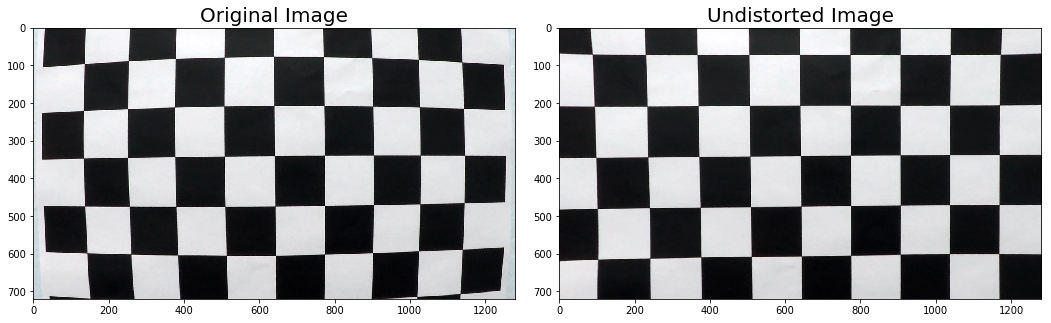

In [14]:
sample = cv2.imread("camera_cal/calibration1.jpg")


def undistort_image(img, camera, dist):
    undis = cv2.undistort(img,camera,dist,None,camera)
    return undis

camera_matrix,distortion_params = cameraProperties()
#Example code to check cmera matx and distortion parameters
undistroted_image = undistort_image(sample,camera_matrix,distortion_params)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.tight_layout()
ax1.imshow(sample)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistroted_image)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



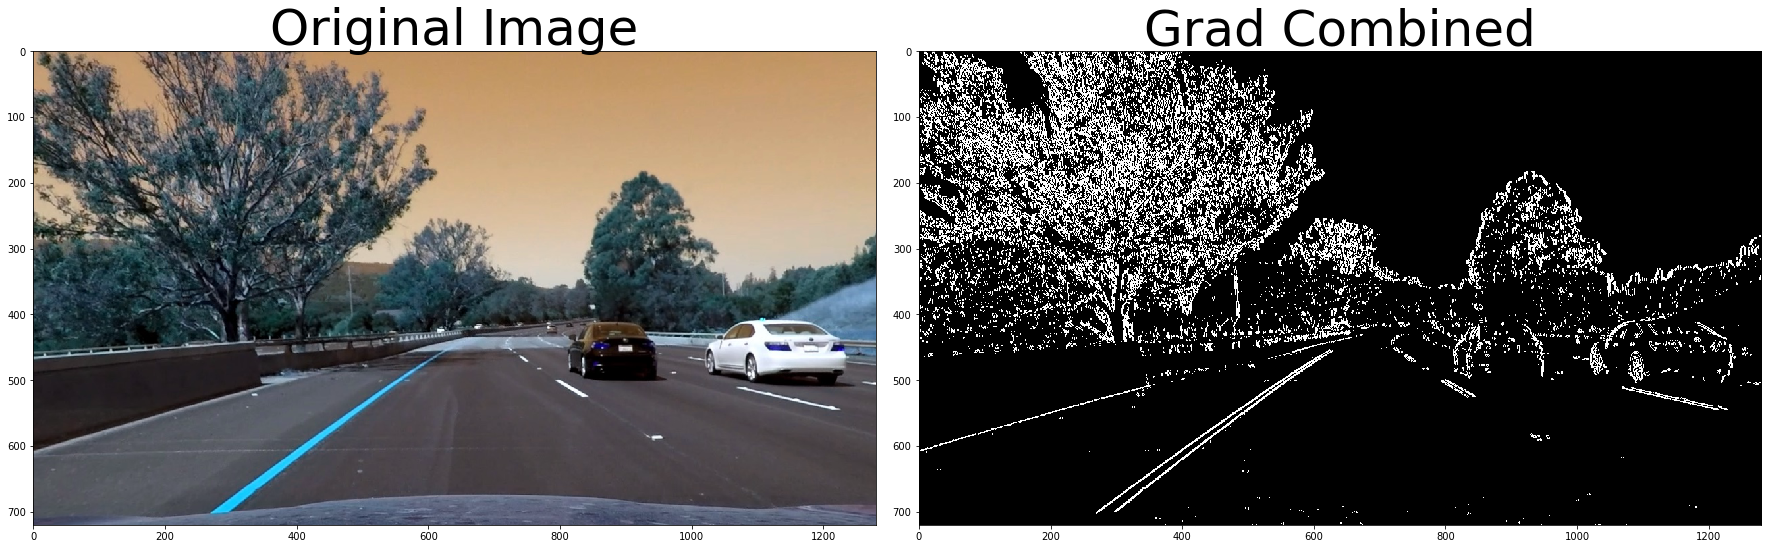

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def abs_sobel_grad(img,sobel_kernel=3, operator_type='x', abs_thresh=(20,100)):
    in_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if operator_type == 'x':
        sobel = cv2.Sobel(in_gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(in_gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    return sbinary


def mag_grad(img, sobel_kernel=3, mag_thresh=(30, 100)):
    in_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(in_gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(in_gray, cv2.CV_64F, 0, 1)
    grad_mag = np.sqrt(sobelx**2,sobely**2)
    scaled_sobel = np.uint8(255 * grad_mag/np.max(grad_mag))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sbinary

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output
    
    
#Applying sobel operators (Gradient operation)
input_image = cv2.imread("test_images/test6.jpg")
input_image = undistort_image(input_image, camera_matrix, distortion_params)
image_sobelx = abs_sobel_grad(input_image, sobel_kernel=3, operator_type='x', abs_thresh=(20,100))
image_sobely = abs_sobel_grad(input_image, sobel_kernel=3, operator_type='y', abs_thresh=(20,100))
image_sobelmag = mag_grad(input_image, sobel_kernel=3, mag_thresh=(30,100))
image_sobeldir = dir_threshold(input_image, sobel_kernel=3, dir_thresh=(0.7,1.3))

combined = np.zeros_like(image_sobeldir)
combined[((image_sobelx == 1) & (image_sobely == 1)) | ((image_sobelmag == 1) & (image_sobeldir == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(input_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Grad Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imshow(image_sobelx, cmap='gray')

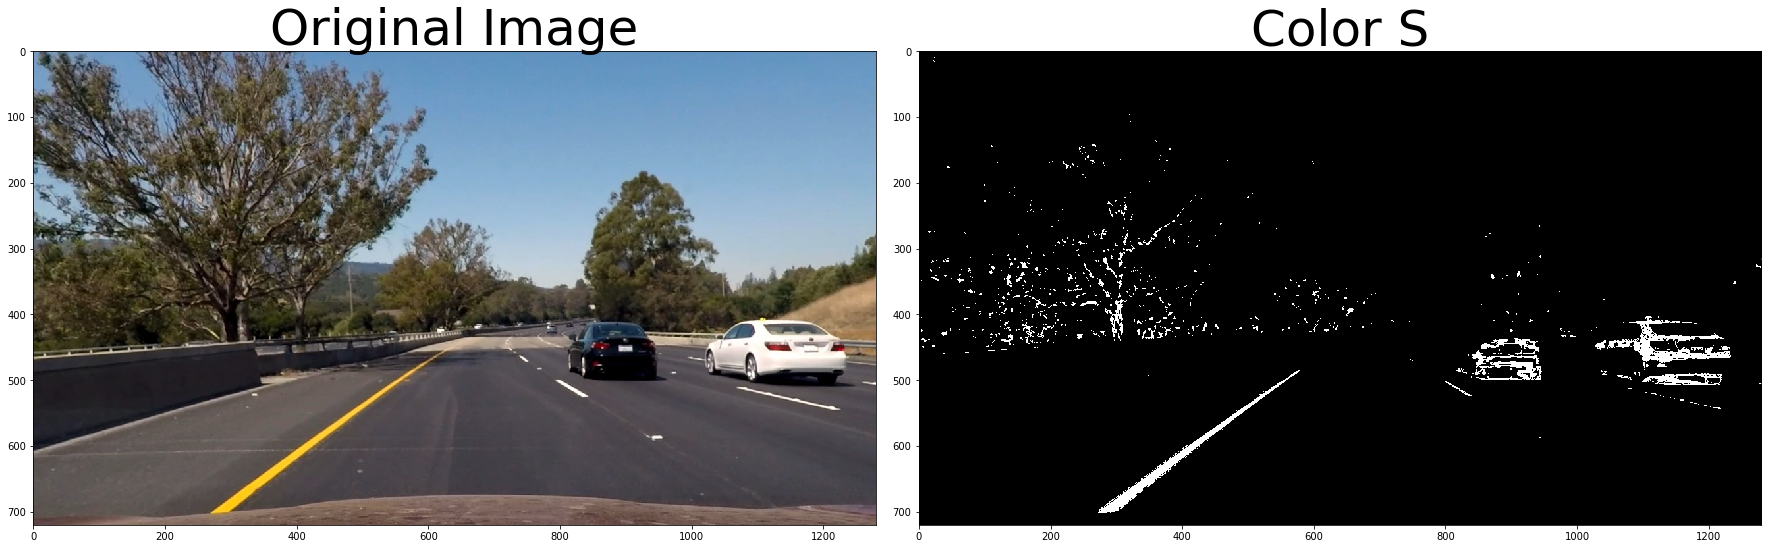

In [24]:
# Applying color thresholds

input_image = cv2.imread("test_images/test6.jpg")
input_image = undistort_image(input_image, camera_matrix, distortion_params)
def hls_select(img, s_thresh=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    return binary
binary = hls_select(input_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Color S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


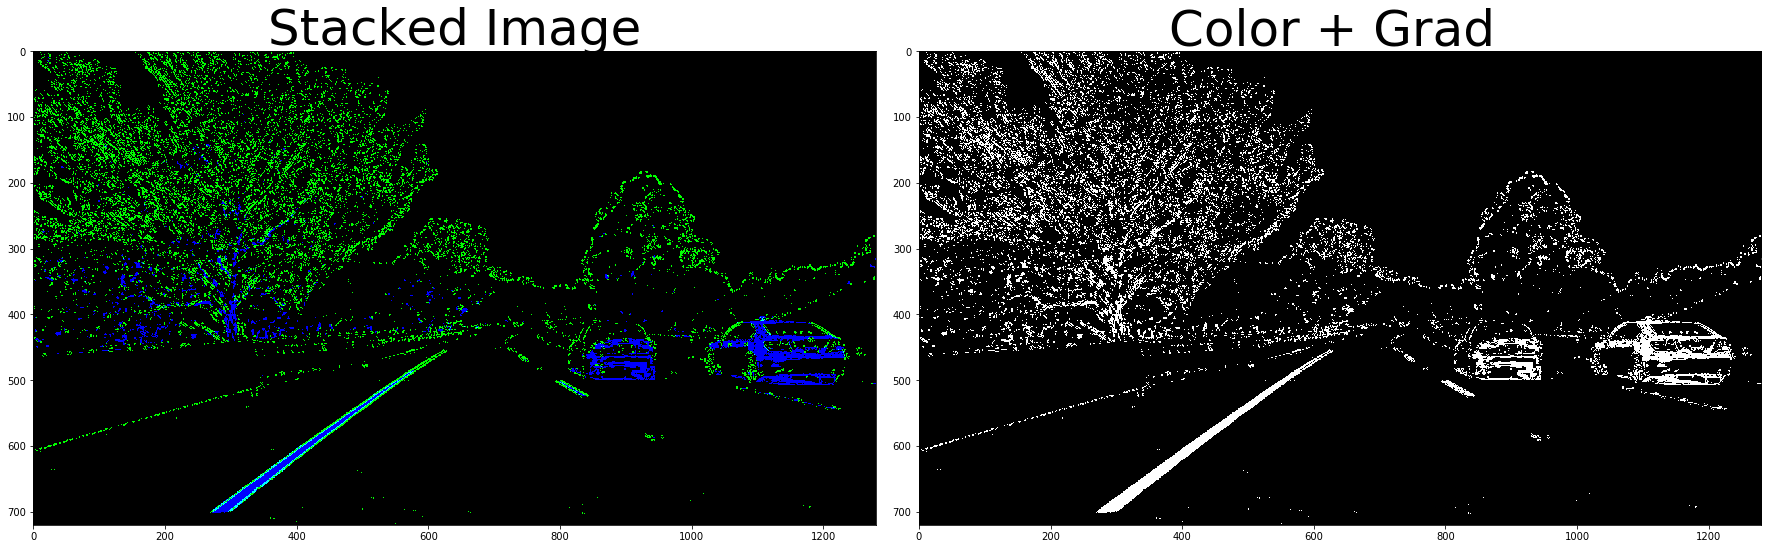

In [25]:
combined_binary = np.zeros_like(combined)
combined_binary[(binary == 1) | (combined == 1)] = 1
color_binary = np.dstack(( np.zeros_like(combined), combined, binary))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary)
ax1.set_title('Stacked Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Color + Grad ', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 1280, 3)


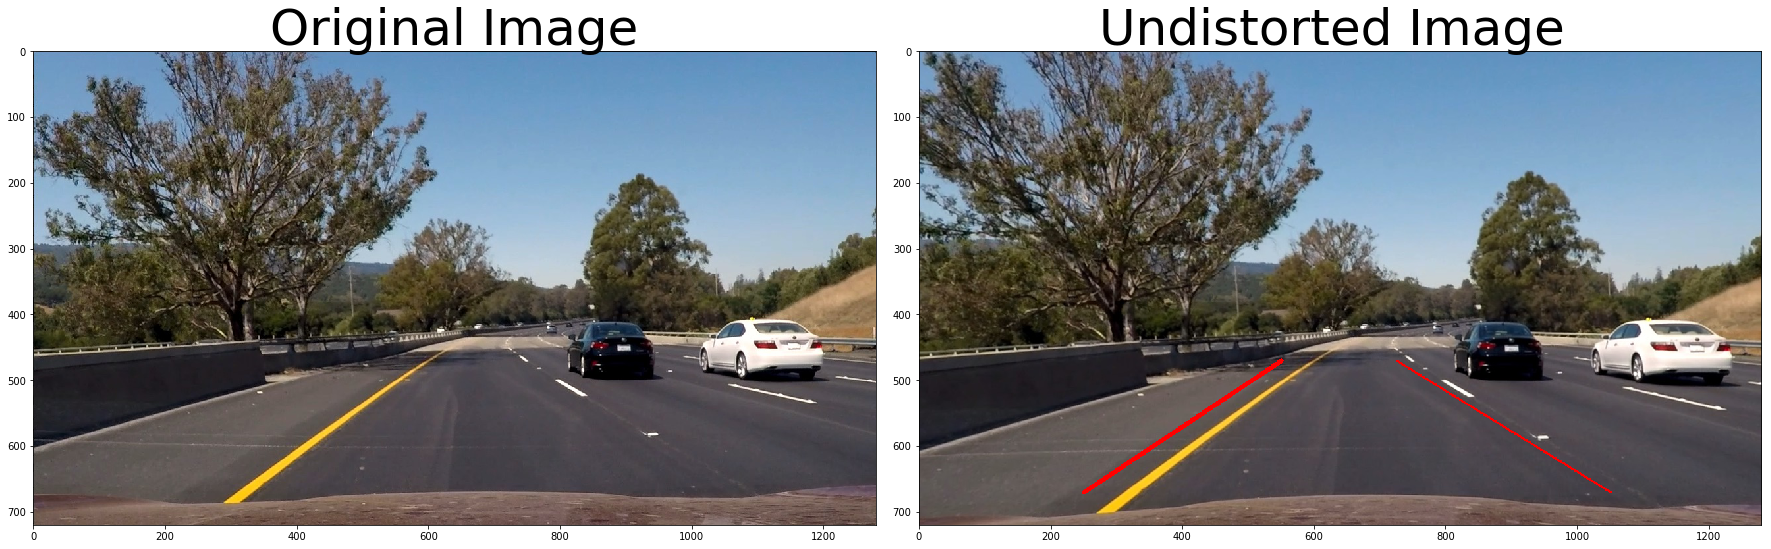

In [26]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#Perform Perspective transform
perspective_input = mpimg.imread("test_images/test6.jpg")
perspective_input_image = undistort_image(perspective_input, camera_matrix, distortion_params)
print(perspective_input_image.shape)
x = perspective_input_image.shape[1]
y = perspective_input_image.shape[0]

presp = cv2.line(perspective_input_image,(250,y-50),(550,470),(255,0,0),5)
presp = cv2.line(presp,(1050,y-50),(725,470),(255,0,0),2)
#plt.imshow(perspective_input_image)
#cv2.imshow("Cool",perspective_input_image)
#cv2.waitKey(5000)
#cv2.destroyAllWindows()
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(perspective_input)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(perspective_input_image, cmap='gray')
ax2.set_title('Undistorted Image ', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


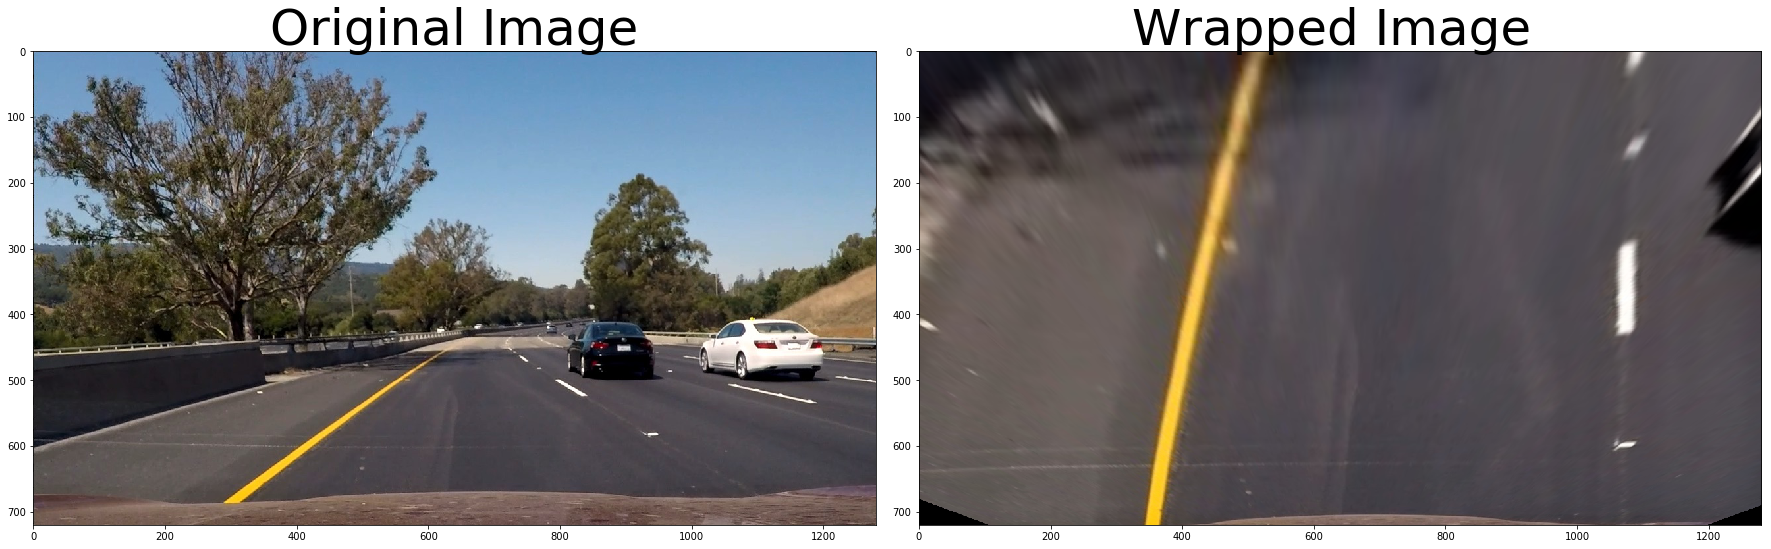

In [27]:

def wrap(img):
    
    #define image size
    img_size = (img.shape[1],img.shape[0])
    
    #select source points
    srcpoint1 = (550,470) #top left
    srcpoint2 = (725,470) #top right
    srcpoint3 = (1050,y-25) #bottom right
    srcpoint4 = (250, y-25) #bottom left

    #select destination points

    dstpoint1 = (320,0) #top left
    dstpoint2 = (1000,0) #top right
    dstpoint3 = (1000, y) #bottom left
    dstpoint4 = (320,y) #bottom right

    #create arrays for src and dst
    src = np.float32([srcpoint1,srcpoint2,srcpoint3,srcpoint4])
    dst = np.float32([dstpoint1,dstpoint2,dstpoint3,dstpoint4])
    
    #get Perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #get wrapped image
    warped = cv2.warpPerspective(img, M, img_size)

    #return image
    return warped

input_image = mpimg.imread("test_images/test6.jpg")
undistorted_image = undistort_image(input_image, camera_matrix, distortion_params)
output_image = wrap(undistorted_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(input_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(output_image)
ax2.set_title('Wrapped Image ', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig("Sample.jpg")


In [8]:
#Creating the entire pipeline

#1. Camera Perspective
camera_matrix,distorted_params = cameraProperties()

100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


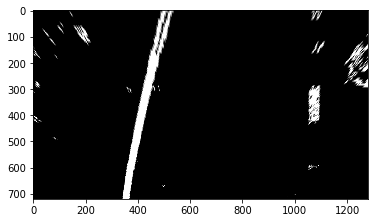

In [28]:
#2. Define the input image
input_image = mpimg.imread("test_images/test6.jpg")

#3. undistort the image
input_image = undistort_image(input_image, camera_matrix, distortion_params)

#4. Color / Gradient operators
#i. Gradient thresholds
image_sobelx = abs_sobel_grad(input_image, sobel_kernel=3, operator_type='x', abs_thresh=(20,100))
image_sobely = abs_sobel_grad(input_image, sobel_kernel=3, operator_type='y', abs_thresh=(20,100))
image_sobelmag = mag_grad(input_image, sobel_kernel=3, mag_thresh=(30,100))
image_sobeldir = dir_threshold(input_image, sobel_kernel=3, dir_thresh=(0.7,1.3))
combined_gradient = np.zeros_like(image_sobeldir)
combined_gradient[((image_sobelx == 1) & (image_sobely == 1)) | ((image_sobelmag == 1) & (image_sobeldir == 1))] = 1
#ii. Color thresholds
color_threshold = hls_select(input_image)
#iii. final result 
combined_binary = np.zeros_like(combined_gradient)
combined_binary[(color_threshold == 1) | (combined_gradient == 1)] = 1

#sample out image
color_binary = np.dstack(( np.zeros_like(combined_gradient), combined_gradient, color_threshold))

#5. Perspective transform
transformed_image = wrap(combined_binary)
plt.imshow(transformed_image, cmap='gray')

(720, 1280)

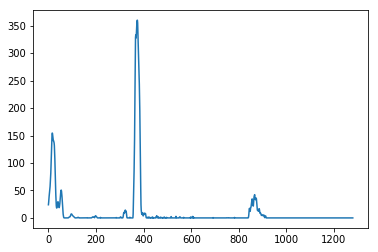

In [27]:
histogram = np.sum(transformed_image[transformed_image.shape[0]//2:,:], axis=0)
plt.plot(histogram)
out_img = np.dstack((transformed_image, transformed_image, transformed_image))*255
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(transformed_image.shape[0]/nwindows)
transformed_image.shape

[ -7.13572976e-05   5.03557116e-02   3.67611985e+02] [ -2.65158788e-04   2.70204577e-01   8.02597757e+02]


(720, 0)

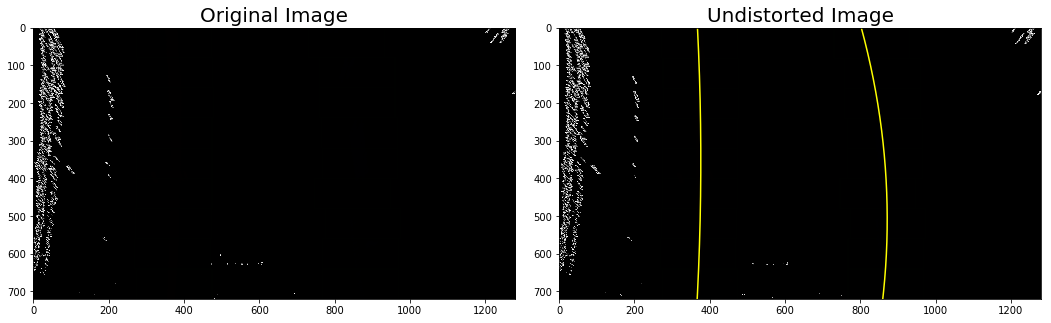

In [30]:

cv2.destroyAllWindows()

nonzero = transformed_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = transformed_image.shape[0] - (window+1)*window_height
    win_y_high = transformed_image.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2)     
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2)
    #cv2.imshow(str(window),out_img)
    #cv2.waitKey(500)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, transformed_image.shape[0]-1, transformed_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print(left_fit,right_fit)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.tight_layout()

ax1.imshow(out_img)
ax1.set_title('Original Image', fontsize=20)
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

ax2.imshow(out_img)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)